In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Error Propagation of Radon transform
Let $I \in \mathbb{N}^{r \times v}$ be a sinogram and the function $f: \mathbb{N}^{r \times v} \rightarrow \mathbb{N}^{n \times n}$ is the inverse radon transorm. Further be $F_x$ the Jacobian of $f$:
\begin{align}
    F_x &= \left[ \nabla f^T \right]^T &= \left[\begin{array}{c}
        f_1 \\
        \vdots \\
        f_{nn}
    \end{array}\right] \left[\begin{array}{ccc} \frac{\partial}{\partial I_1} & \dots & \frac{\partial}{\partial I_{rn}} \end{array}\right] &= \left[\begin{array}{ccc}
        \frac{\partial f_1}{\partial I_1} & \dots & \frac{\partial f_1}{\partial I_{rv}} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_{nn}}{\partial I_1} & \dots & \frac{\partial f_{nn}}{\partial I_{rv}}
    \end{array}\right]
\end{align}

We now assume that $I$~$\mathcal{N}(\mu, \Sigma)$ is a realization of a multivariate normal distribution. The covariance matrix $\Sigma$ can be modelled in a way, that the correlation factor $\rho(i, j)$ is higher for columns $j$ and stays constant for rows $i$. We use exponential decay for the columns:
$$
    \rho(i) = exp( - \gamma i)
$$

The propagation of the uncertanty $\Sigma$ can be computed as followed:
$$
    \Sigma_f = F_x \Sigma F_x^T
$$

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import tensorflow as tf
import tensorflow_probability as tfp
from skimage import transform
from scipy.interpolate import interp1d
from error_propagation_radon_transform import utils

import importlib
importlib.reload(utils)

from ipywidgets import interact, widgets, interactive_output
from IPython.display import display

# Exponential Decay
$$
    \rho(i) = \exp(-\gamma i)
$$

In [3]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

@interact(width=(2,50))
def interactive_exponential(width=15):
    x = np.arange(0,width)
    y = exponential(x, 1/np.log(width))
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=15, description='width', max=50, min=2), Output()), _dom_classes=('widge…

# Linear decay
\begin{align}
    r(h) &= - \gamma h + 1, & \gamma &\in (0,1)
\end{align}

In [3]:
def linear(value, gamma):
    return - gamma * value + 1

@interact(width=(1,50))
def interactive_linear(width=15):
    x = np.arange(0,width)
    y = linear(x, 1/width)
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=15, description='width', max=50, min=1), Output()), _dom_classes=('widge…

# Covariance Matrix

In [4]:
@interact(width=(1, 32))
def interact_cov(width=10):
    var = np.ones((16,16))
    covar = utils.build_covariance_y(var, function=exponential, width=width)

    impulse = np.zeros_like(var)
    impulse[var.shape[0]//2, var.shape[1]//2] = 1.0

    response = covar @ impulse.flatten()

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.imshow(covar)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(response.reshape(var.shape))
    plt.colorbar()
    plt.show()
    
    plt.plot(response.reshape(var.shape)[var.shape[0]//2:, var.shape[1]//2])
    plt.show()

interactive(children=(IntSlider(value=10, description='width', max=32, min=1), Output()), _dom_classes=('widge…

In [5]:
kidney = np.loadtxt('../Data/kidney.csv', delimiter=',', skiprows=1, usecols=(0), dtype=np.float32).reshape((512,512))

#enforce to be zero on the edges
kidney[:,:10] = 50
kidney[:,-10:] = 50
kidney[:10,:] = 50
kidney[-10:,:] = 50

kidney = kidney[::8,::8]
img_shape = kidney.shape[0]

print(kidney.shape)

(64, 64)


(64, 64)


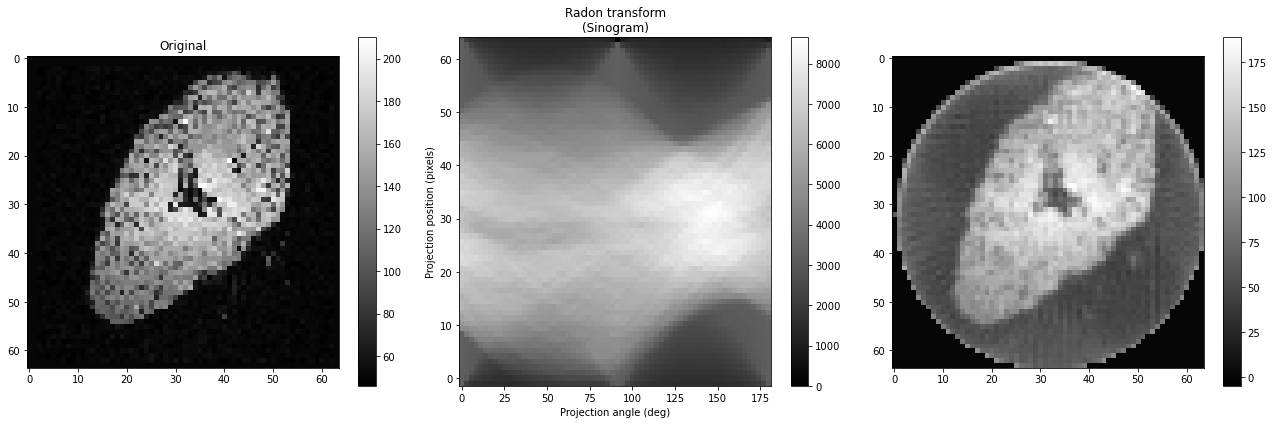

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title('Original')
kid = ax1.imshow(kidney, cmap='gray')

plt.colorbar(kid, ax=ax1)

theta = np.linspace(0., 180., max(kidney.shape), endpoint=False)
sinogram = transform.radon(kidney, theta=theta)
dx, dy = 0.5 * 180.0 / max(kidney.shape), 0.5 / sinogram.shape[0]
ax2.set_title('Radon transform\n(Sinogram)')
ax2.set_xlabel('Projection angle (deg)')
ax2.set_ylabel('Projection position (pixels)')
sin = ax2.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')

print(sinogram.shape)

plt.colorbar(sin, ax=ax2)

reconstructed = transform.iradon(sinogram, theta=theta, filter_name='ramp')
re = ax3.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax3)

fig.tight_layout()
plt.show()

In [7]:
prog = widgets.FloatProgress(
    value=0,
    min=0,
    max=10 + img_shape,
    description='Loading:',
    bar_style='info',
    orientation='horizontal'
)

display(prog)
@interact(width=(1, 30), filter_name=['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None], percent=(0,100,10))
def show_radon_transform(filter_name='ramp', width=10, percent=10):
    prog.bar_style = 'info'
    prog.value = 0
    
    jacobian, kidney_reconstructed = utils.compute_gradient(sinogram, theta, kidney.shape, filter_name, prog)
    
    prog.value += 1
    
    input_range = sinogram.max() - sinogram.min()
    output_range = tf.reduce_max(kidney_reconstructed) - tf.reduce_min(kidney_reconstructed)
    print(input_range)
    
    var = np.ones_like(sinogram) * 1100
    Sigma_in = utils.build_covariance_y(var, function=exponential, width=width)
    
    prog.value += 1
    
    n = np.prod(kidney.shape)
    jacobian_reshaped = tf.reshape(jacobian, (n, n))
    
    Sigma = jacobian_reshaped @ Sigma_in @ tf.transpose(jacobian_reshaped)
    
    variance = tf.reshape(tf.abs(tf.linalg.tensor_diag_part(Sigma)), kidney.shape)
    
    if filter_name == None:
        filter_name = 'None'
    
    np.save('../Data/iradon/mu_'+filter_name+'.npy', kidney_reconstructed)
    np.save('../Data/iradon/df_dx_'+filter_name+'.npy', jacobian_reshaped)
        
    prog.value += 1

    plt.figure(figsize=(18,12))
    plt.subplot(2,2,1)
    plt.title('Sinogram')
    plt.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')
    plt.colorbar()
    
    prog.value += 1

    plt.subplot(2,2,2)
    plt.title('inverse Radon transform')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.colorbar()
    
    prog.value += 1

    plt.subplot(2,2,3)
    plt.title(r'$\Sigma$')
    plt.imshow(Sigma_in)
    plt.colorbar()
    
    prog.value += 1
    
    plt.subplot(2,2,4)
    plt.title(r'$\sigma^2_f$')
    plt.imshow(variance)
    plt.colorbar()
    
    plt.show()
    
    prog.bar_style = 'success'
    prog.value += 1

FloatProgress(value=0.0, bar_style='info', description='Loading:', max=74.0)

interactive(children=(Dropdown(description='filter_name', options=('ramp', 'shepp-logan', 'cosine', 'hamming',…

In [19]:
jacobian, kidney_reconstructed = utils.compute_gradient(sinogram, theta, kidney.shape, 'shepp-logan', None)
    
input_range = sinogram.max() - sinogram.min()
output_range = tf.reduce_max(kidney_reconstructed) - tf.reduce_min(kidney_reconstructed)
    
var = np.ones_like(sinogram) * 30
Sigma_in = utils.build_covariance_y(var, function=exponential, width=5)

n = np.prod(kidney.shape)
jacobian_reshaped = tf.reshape(jacobian, (n, n))

Sigma = jacobian_reshaped @ Sigma_in @ tf.transpose(jacobian_reshaped)

In [21]:
def plot_transform(x, y):
    variance = tf.reshape(tf.linalg.tensor_diag_part(Sigma), kidney_reconstructed.shape)
    
    
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.title('reconstructed')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    plt.subplot(1,3,2)
    plt.title(r'$real(\sigma^2)$')
    plt.imshow(tf.math.real(variance), cmap='gray')
    plt.colorbar()
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    plt.subplot(1,3,3)
    plt.title(r'$imag(\sigma^2)$')
    plt.imshow(tf.math.imag(variance), cmap='gray')
    plt.colorbar()
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    
    plt.show()
    
def plot_covar(x, y):
    y = kidney_reconstructed.shape[1] - 1 - y
    
    idx = kidney_reconstructed.shape[0] * y + x
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title(r'$real(\Sigma)|_{xy}$')
    plt.imshow(tf.math.real(tf.reshape(Sigma[idx,:], kidney_reconstructed.shape)))
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title(r'$imag(\Sigma)|_{xy}$')
    plt.imshow(tf.math.imag(tf.reshape(Sigma[idx,:], kidney_reconstructed.shape)))
    plt.colorbar()
    plt.show()

x_slider = widgets.IntSlider(32, 0, kidney_reconstructed.shape[0]-1, 1, description='x', layout=widgets.Layout(left='-60px', width='390px'))
y_slider = widgets.IntSlider(32, 0, kidney_reconstructed.shape[0]-1, 1, description='y', orientation='vertical', layout=widgets.Layout(top='-15px', height='290px'))

transform_ui = interactive_output(plot_transform, {
    'x': x_slider,
    'y': y_slider
})
covar_ui = interactive_output(plot_covar, {
    'x': x_slider,
    'y': y_slider
})

layout = widgets.HBox([
    y_slider,
    widgets.VBox([
        transform_ui,
        x_slider
    ])
])

display(widgets.VBox([
    layout,
    covar_ui
]))

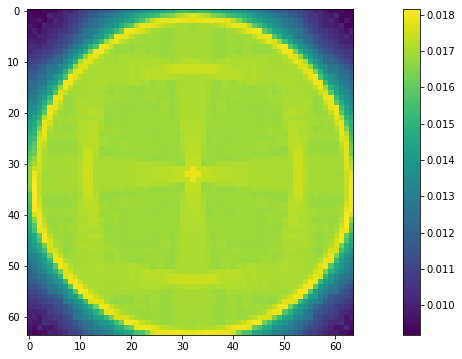

In [14]:
Sigma_cleaned = tf.math.real(Sigma).numpy()
for i in range(Sigma.shape[0]):
    Sigma_cleaned[i,i] = 0
summed = tf.reduce_max(tf.math.real(Sigma_cleaned), axis=0)

plt.figure(figsize=(18,6))
plt.imshow(tf.reshape(summed, kidney_reconstructed.shape))
plt.colorbar()
plt.show()

In [9]:
print('jacobian:', np.prod([262144,524288]) * 8 / 2**30, 'GByte')
#print('Σ:', np.prod(Sigma_in.shape) * 4 / 2**20, 'MByte')

jacobian: 1024.0 GByte


<div style="height: 300px"></div>

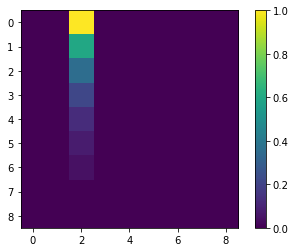

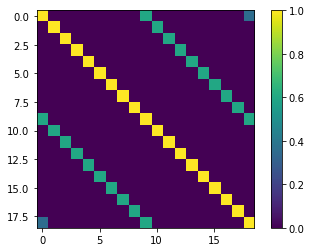

In [89]:
def build_covariance_y(variance, function, width=3):
    '''
    Generate a covariance matrix, which covariance is along the 
    y-dimension of a grid.

    Parameter
    ---------
    variance: array_like
        A 2D array of variances for each pixel.
    '''
    
    im_height, im_width = variance.shape
    n = im_height * im_width
    var = np.diagflat(variance.flatten())
    
    for p in range(n):
        idy = utils.get_neigbours_y(p, width, im_height, im_width)
        
        omega = np.arange(0,width+1)
        rho = function(omega, 1/np.log(width+1))
        
        top = 1
        bottom = min(width, p//im_width)
        for idx in idy:
            if p < idx:
                # bottom
                #var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                top += 1
            if p > idx:
            #    # top
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[bottom]
            #    var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * bottom
                bottom -= 1
            
    return var
            
var = np.ones((9,9))
Sigma = build_covariance_y(var, exponential, 6)

impulse = np.zeros((9,9))
impulse[0,2] = 1

response = np.reshape(Sigma @ impulse.flatten(), (9,9))

plt.imshow(response)
plt.colorbar()
plt.show()

plt.imshow(Sigma[:19,:19])
plt.colorbar()
plt.show()

#plt.plot(response[:,4])
#plt.show()